# Uber Prediction for Analyzing New Drivers

### By Kento Morita, Vincent Perez, Ariel Liang, Phuong Duong

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

## 1. Data Wrangling / EDA
#### Since we created new variables in Excel(name: driver_signup_processed.csv) beforehand, please let us write down all of columns which created in Excel process.
- days_to_bgc: The gap of day difference between signup_date and bgc_date
- days_to_vehicle_add: The gap of day difference between signup_date and vehicle_added_date
- days_to_first_trip: The gap of day difference between signup_date and first_completed_date
- started_driving: Convert binary variable if first_completed_date has 1, otherwise 0.

In [9]:
data = pd.read_csv('./dataset/driver_signup_processed.csv')

In [10]:
#explore dataset features
data.info()
data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54681 entries, 0 to 54680
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    54681 non-null  int64  
 1   city_name             54681 non-null  object 
 2   signup_os             47824 non-null  object 
 3   signup_channel        54681 non-null  object 
 4   signup_date           54681 non-null  object 
 5   bgc_date              32896 non-null  object 
 6   vehicle_added_date    13134 non-null  object 
 7   vehicle_make          13223 non-null  object 
 8   vehicle_model         13223 non-null  object 
 9   vehicle_year          13223 non-null  float64
 10  first_completed_date  6137 non-null   object 
 11  days_to_bgc           32896 non-null  float64
 12  days_to_vehicle_add   13134 non-null  float64
 13  days_to_first_trip    6137 non-null   float64
 14  started_driving       54681 non-null  int64  
dtypes: float64(4), int6

(54681, 15)

In [11]:
#null value counts
data.isna().sum()

id                          0
city_name                   0
signup_os                6857
signup_channel              0
signup_date                 0
bgc_date                21785
vehicle_added_date      41547
vehicle_make            41458
vehicle_model           41458
vehicle_year            41458
first_completed_date    48544
days_to_bgc             21785
days_to_vehicle_add     41547
days_to_first_trip      48544
started_driving             0
dtype: int64

#### Impute missing values

In [12]:
## Since we have to handle the number of days and missing value differently, we put -1 for missing value in categorical variable.
from sklearn.impute import SimpleImputer
num_cols = ['days_to_bgc', 'days_to_vehicle_add']
cat_cols = ['signup_os', 'signup_channel', 'city_name']

data[num_cols] = SimpleImputer(strategy='constant', fill_value=-1).fit_transform(data[num_cols])
data[cat_cols] = SimpleImputer(strategy='constant', fill_value=0).fit_transform(data[cat_cols])

#### Correlation Matrix Heatmap

In [71]:
data[num_cols + ["started_driving"]].corr()

,days_to_bgc,days_to_vehicle_add,started_driving
days_to_bgc,1.000000,0.328207,-0.084034
days_to_vehicle_add,0.328207,1.000000,0.103106
started_driving,-0.084034,0.103106,1.000000


#### Plot total completed drivers amount by each day

[]

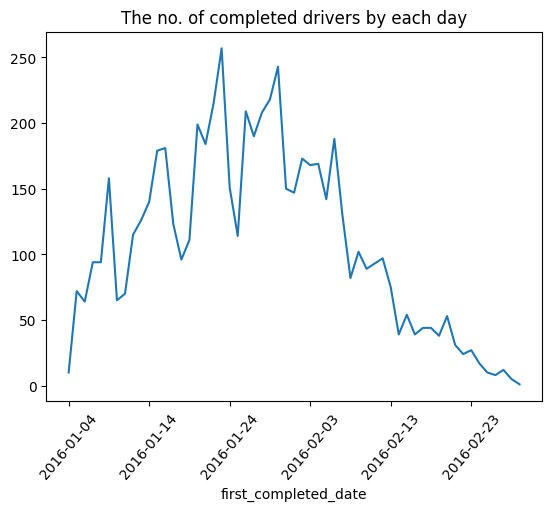

In [31]:
data.groupby("first_completed_date")["id"].count().plot(kind="line")
plt.xticks(rotation=50)
plt.title("The no. of completed drivers by each day")
plt.plot()

#### groupby each signup device and channel to compute the total number of new drivers within the timeframe

In [15]:
data[data['signup_os']!=0].groupby(['signup_os','signup_channel']).size().to_frame('number_drivers')

number_drivers
signup_os   signup_channel                
android web Organic                   2786
            Paid                      7871
            Referral                  4287
ios web     Organic                   3527
            Paid                      7723
            Referral                  5382
mac         Organic                   1796
            Paid                      2615
            Referral                  1413
other       Organic                    925
            Paid                      2017
            Referral                   706
windows     Organic                   1861
            Paid                      3609
            Referral                  1306

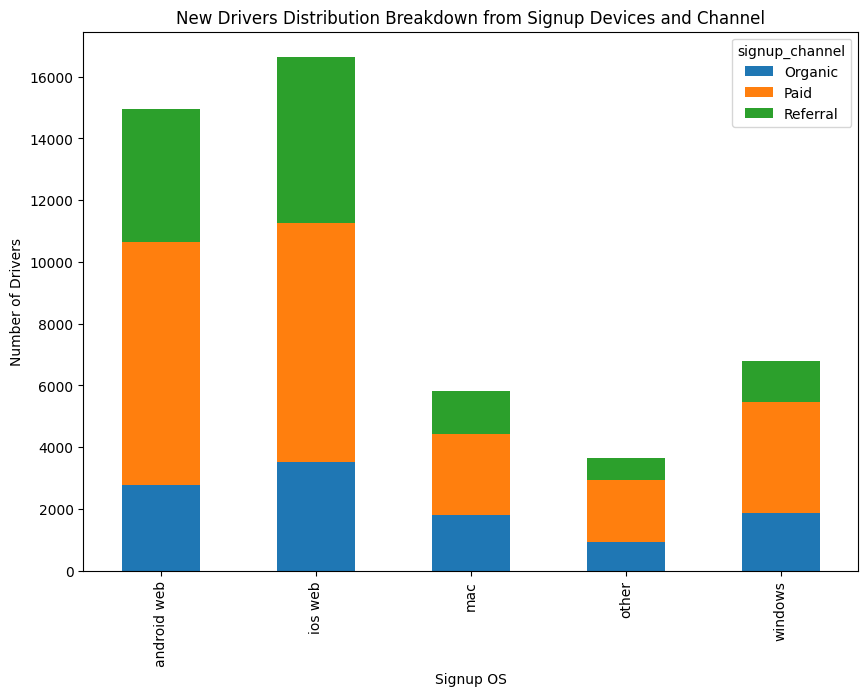

In [16]:
# Reshape dataframe to pivot the data
df1 = data[data['signup_os']!=0].groupby(['signup_os','signup_channel']).size().to_frame('number_drivers').reset_index().pivot(index='signup_os', columns='signup_channel', values='number_drivers')

# Plot stacked bar chart
df1.plot(kind='bar', stacked=True, figsize=(10,7))

# Add labels and title
plt.xlabel('Signup OS')
plt.ylabel('Number of Drivers')
plt.title('New Drivers Distribution Breakdown from Signup Devices and Channel')

# Show plot
plt.show()

#### Which city attracts the most new drivers signing up ?

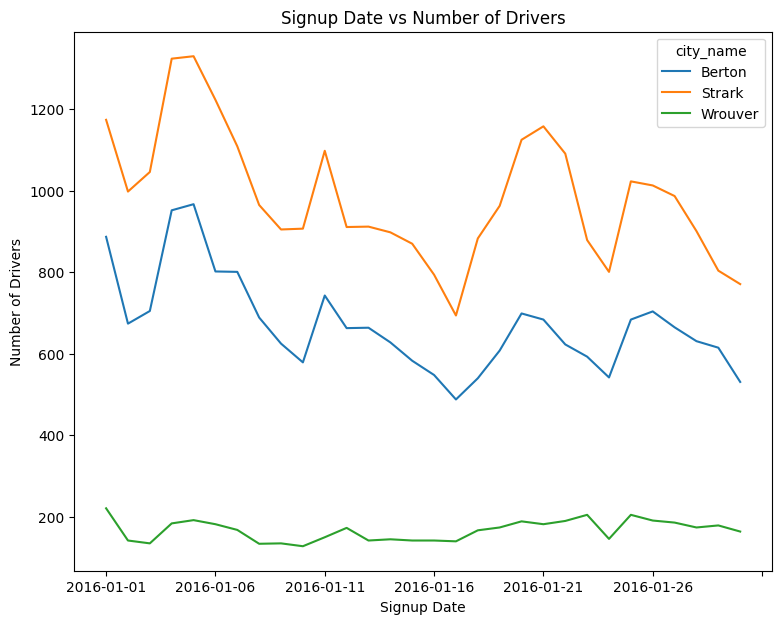

In [21]:
df2=data.groupby(['signup_date','city_name']).size().to_frame('number_of_drivers').reset_index()
df2 = df2.pivot(index='signup_date', columns='city_name', values='number_of_drivers')
#visualize the dataframe above
df2.plot(kind='line',figsize=(9,7))
plt.xlabel('Signup Date')
plt.ylabel('Number of Drivers')
plt.title('Signup Date vs Number of Drivers')
plt.show()

#### The distribution difference of ["days_to_bgc", "days_to_vehicle_add"] between started_driving

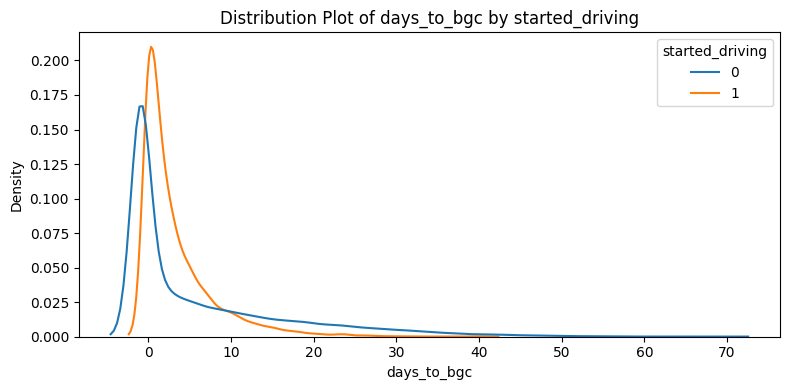

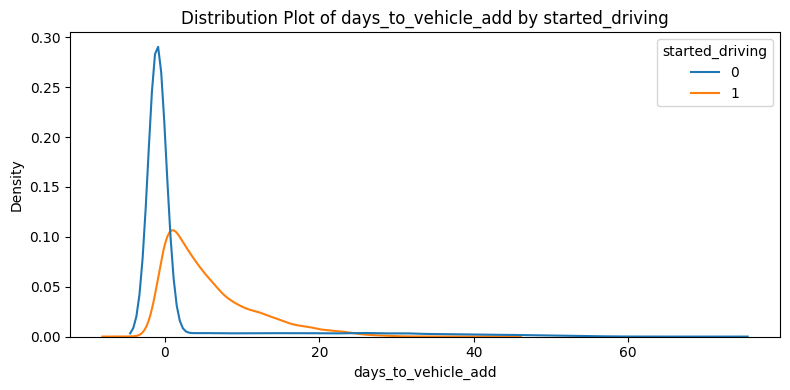

In [29]:
# Drop missing values in required columns
cols = ["days_to_bgc", "days_to_vehicle_add"]
kde_data = data[cols+["started_driving"]].dropna()

# Plot KDEs
for col in cols:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(
        data=kde_data,
        x=col,
        hue="started_driving",
        common_norm=False
    )
    plt.title(f"Distribution Plot of {col} by started_driving")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()

## 2. Feature Engineering

In [32]:
data.columns

Index(['id', 'city_name', 'signup_os', 'signup_channel', 'signup_date',
       'bgc_date', 'vehicle_added_date', 'vehicle_make', 'vehicle_model',
       'vehicle_year', 'first_completed_date', 'days_to_bgc',
       'days_to_vehicle_add', 'days_to_first_trip', 'started_driving'],
      dtype='object')

In [41]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_values = scaler.fit_transform(data[num_cols])
scaled_col_names = [col + '_scaled' for col in num_cols]
for i, col in enumerate(scaled_col_names):
    data[col] = scaled_values[:, i]

## Modeling

### Random Forest

In [45]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [46]:
# Target and features
x_num_cols = ['days_to_bgc_scaled', 'days_to_vehicle_add_scaled']
x_cat_cols = ['signup_os', 'signup_channel', 'city_name']
target = 'started_driving'

# One-hot encode categorical features
df_encoded = pd.get_dummies(data[x_num_cols+x_cat_cols], drop_first=True)

# Split into features and target
X = df_encoded
y = data[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
report_rf_df = pd.DataFrame(report_rf).transpose()

report_rf_df

,precision,recall,f1-score,support
0,0.966017,0.960841,0.963422,9704.000000
1,0.704280,0.733982,0.718824,1233.000000
accuracy,0.935266,0.935266,0.935266,0.935266
macro avg,0.835149,0.847412,0.841123,10937.000000
weighted avg,0.936510,0.935266,0.935847,10937.000000


### Random Forest & SMOTE with GridSearch

In [47]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

In [51]:
# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Hyperparameter tuning grid
param_grid = {
    'n_estimators': [100],
    'max_depth': [1, 3, 9, 10],
    'min_samples_split': [1, 2, 3],
    'min_samples_leaf': [1, 2, 3]
}

# Grid Search with 10-fold cross-validation
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1',
    cv=10,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train_resampled, y_train_resampled)

# Predict and evaluate
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Best Parameters:", grid_search.best_params_)
print(classification_report(y_test, y_pred))

/Users/moritakento/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
120 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/moritakento/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/moritakento/Library/Python/3.9/lib/python/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Users/moritakento/Library/Python/3.9/lib/python/site-packages/sklearn/base.py", line 666, in _validate_params
    

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.99      0.92      0.96      9704
           1       0.60      0.94      0.74      1233

    accuracy                           0.92     10937
   macro avg       0.80      0.93      0.85     10937
weighted avg       0.95      0.92      0.93     10937



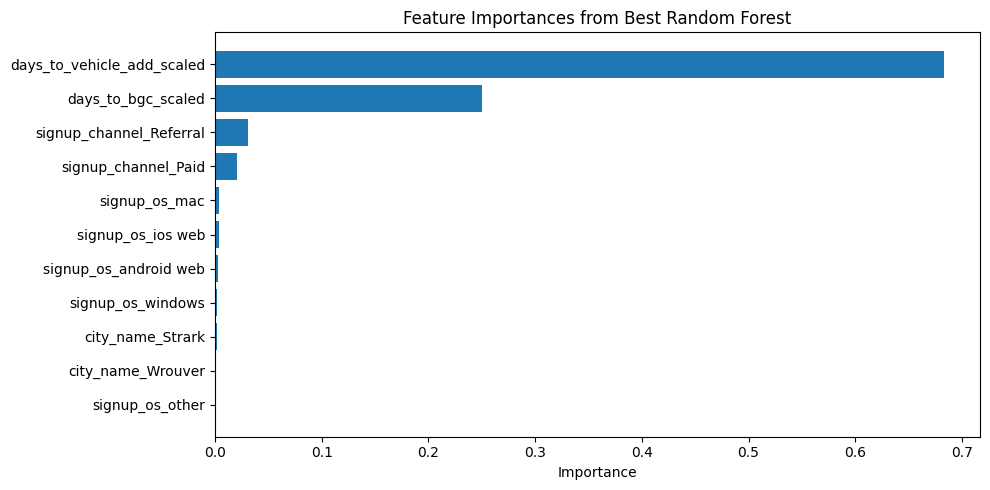

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances
importances = best_model.feature_importances_
feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f"feature_{i}" for i in range(X_train.shape[1])]

# Create and plot DataFrame
feat_imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values(by='importance', ascending=False)

# Plot
plt.figure(figsize=(10, 5))
plt.barh(feat_imp_df['feature'], feat_imp_df['importance'])
plt.gca().invert_yaxis()
plt.title('Feature Importances from Best Random Forest')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

### Try Logistic Regression, Gradient Boosting, Support Vector Machine and K Neighborhood Classifier

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
#import xgboost as xgb
#import lightgbm as lgb
from sklearn.metrics import classification_report

# Dictionary of models to evaluate
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Support Vector Machine": SVC(probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

# Store reports
model_reports = {}

# Fit, predict and evaluate each model
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    model_reports[name] = pd.DataFrame(report).transpose()
    print(name)
    print(model_reports[name])

Logistic Regression
              precision    recall  f1-score       support
0              0.952538  0.742477  0.834492   9704.000000
1              0.259117  0.708840  0.379505   1233.000000
accuracy       0.738685  0.738685  0.738685      0.738685
macro avg      0.605827  0.725659  0.606998  10937.000000
weighted avg   0.874364  0.738685  0.783198  10937.000000
Gradient Boosting
              precision    recall  f1-score       support
0              0.992898  0.922094  0.956187   9704.000000
1              0.607273  0.948094  0.740342   1233.000000
accuracy       0.925025  0.925025  0.925025      0.925025
macro avg      0.800086  0.935094  0.848265  10937.000000
weighted avg   0.949424  0.925025  0.931854  10937.000000
Support Vector Machine
              precision    recall  f1-score       support
0              0.992404  0.915499  0.952401   9704.000000
1              0.586902  0.944850  0.724052   1233.000000
accuracy       0.918808  0.918808  0.918808      0.918808
macro avg  

### Gradient Boosting with GridSearch

In [60]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3],
    'subsample': [0.8, 1.0]
}

# Instantiate model
gb_model = GradientBoostingClassifier(random_state=42)

# Grid Search with 5-fold cross-validation
grid_search_gb = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid,
    scoring='f1',
    cv=10,
    n_jobs=-1,
    verbose=1
)

# Fit model
grid_search_gb.fit(X_train_resampled, y_train_resampled)

# Best model and evaluation
best_gb = grid_search_gb.best_estimator_
y_pred_gb = best_gb.predict(X_test)

print("Best Parameters:", grid_search_gb.best_params_)
print("Classification Report:")
print(classification_report(y_test, y_pred_gb))

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


Best Parameters: {'learning_rate': 0.05, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300, 'subsample': 1.0}
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      9704
           1       0.68      0.83      0.74      1233

    accuracy                           0.94     10937
   macro avg       0.83      0.89      0.85     10937
weighted avg       0.94      0.94      0.94     10937



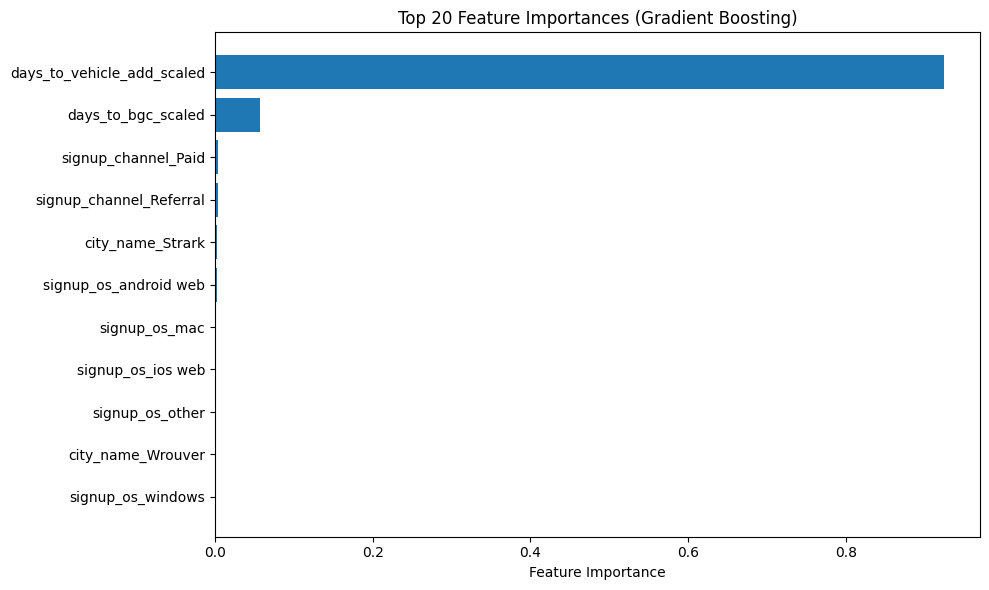

In [61]:
# Get feature importances from the best model
importances = best_gb.feature_importances_
feature_names = X_train.columns  # assumes X_train is a DataFrame

# Create DataFrame for plotting
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['feature'][:20], feat_imp_df['importance'][:20])
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances (Gradient Boosting)')
plt.tight_layout()
plt.show()

In [62]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [63]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

/Users/moritakento/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:
# Define the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=1000,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Predict on test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Classification report
print(classification_report(y_test, y_pred))

/Users/moritakento/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 488us/step - accuracy: 0.8610 - loss: 0.2984 - val_accuracy: 0.9368 - val_loss: 0.1517
Epoch 2/1000
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/step - accuracy: 0.9351 - loss: 0.1542 - val_accuracy: 0.9401 - val_loss: 0.1424
Epoch 3/1000
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.9408 - loss: 0.1425 - val_accuracy: 0.9395 - val_loss: 0.1393
Epoch 4/1000
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.9416 - loss: 0.1385 - val_accuracy: 0.9407 - val_loss: 0.1380
Epoch 5/1000
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.9431 - loss: 0.1360 - val_accuracy: 0.9415 - val_loss: 0.1390
Epoch 6/1000
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 466us/step - accuracy: 0.9419 - loss: 0.1386 - val_accuracy: 0.9424 - val_loss: 0.1363
Epoch 7/1000
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.9439 - loss: 0.1324 - val_accuracy: 0.9415 - val_loss: 0.1362
Epoch 8/1000
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - ac